In [6]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

# Load Data

In [4]:
# Read the data file into a data frame
df = pd.read_csv('https://raw.githubusercontent.com/CaptnBigShot/bank_marketing/master/personal_loan_data.csv', delimiter='\t')

Display a few data rows.

In [5]:
df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


Display data columns.

In [4]:
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'PersonalLoan', 'SecuritiesAccount',
       'CDAccount', 'Online', 'CreditCard'],
      dtype='object')

Display statistics on data columns.

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


The minimum value for Experience is -3, indicating there are people who somehow have negative years of experience. This may need to be corrected after further analysis.
The ZIPCode value could be interpreted as a continuous value, which could be problematic for over-fitting. If it's deemed a valuable feature, it may be best to encode it as a categorical value.

Display unique values for each data column.

In [6]:
df.nunique()

ID                   5000
Age                    45
Experience             47
Income                162
ZIPCode               467
Family                  4
CCAvg                 108
Education               3
Mortgage              347
PersonalLoan            2
SecuritiesAccount       2
CDAccount               2
Online                  2
CreditCard              2
dtype: int64

# Data Processing

The vast majority of observations in the data set declined the PersonalLoan. This imbalance will need to be accounted for throughout the processing, training, testing, and modeling phases.

([<matplotlib.patches.Wedge at 0x7f958c3da898>,
 [Text(-1.6376779685052536, -0.860529413484807, 'Declined'),
  Text(1.4606317375690503, 0.7674991382444789, 'Accepted')],
 [Text(-0.9737544677598804, -0.511666137747723, '90.4%'),
  Text(0.7967082204922091, 0.4186358935878975, '9.6%')])

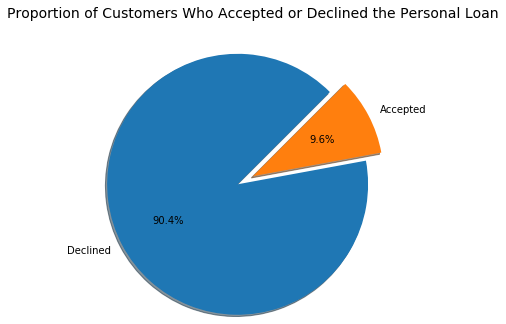

In [7]:
series = df['PersonalLoan'].value_counts()

plt.axis('equal')
plt.title('Proportion of Customers Who Accepted or Declined the Personal Loan', fontsize=14, y=1.2)
labels = ['Declined', 'Accepted']
plt.pie(series, labels=labels, autopct='%1.1f%%', shadow=True, explode=(0.2, 0), radius=1.5, startangle=45)

### Correlation Matrix
Using a correlation matrix, relationships between features can be quickly identified.

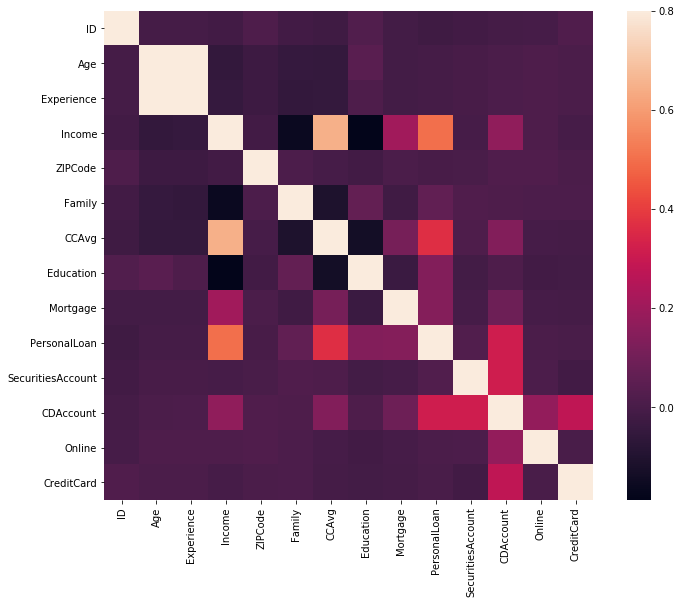

In [8]:
correlation_matrix = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation_matrix, vmax=.8, square=True)

A close-up correlation matrix displays the most significant feature correlations.

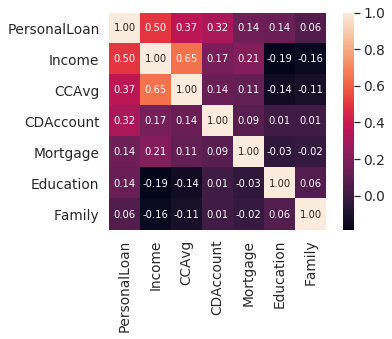

In [9]:
top_correlation_cols = correlation_matrix.nlargest(7, 'PersonalLoan')['PersonalLoan'].index
top_correlation_matrix = np.corrcoef(df[top_correlation_cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(top_correlation_matrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=top_correlation_cols.values, xticklabels=top_correlation_cols.values)

### Recursive Feature Elimination

In [10]:
X = df.drop(columns=['ID', 'PersonalLoan', 'ZIPCode', 'Experience'], inplace=False)
target = df.PersonalLoan

rfc = RandomForestClassifier(random_state=27)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=27,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [11]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 6


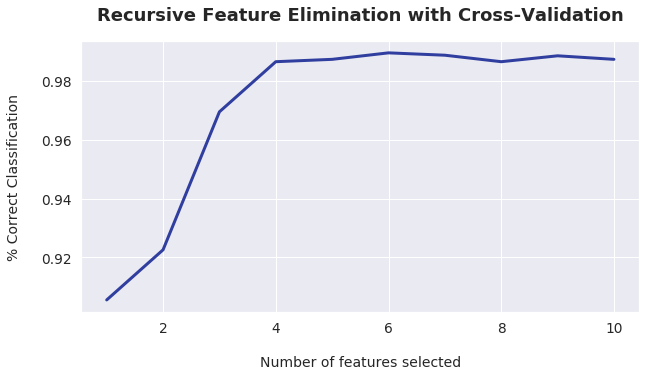

In [12]:
plt.figure(figsize=(10, 5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

In [13]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[5 6 8 9]


Text(0.5, 0, 'Importance')

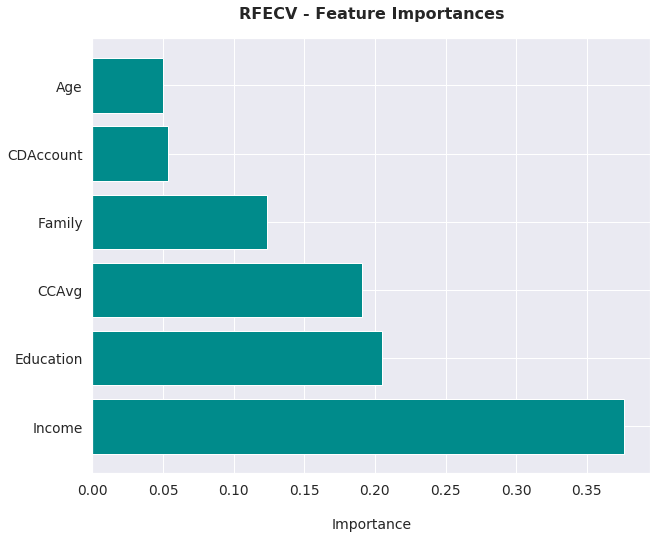

In [14]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(y=dset['attr'], width=dset['importance'], color='darkcyan')
plt.title('RFECV - Feature Importances', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)

## Visualizations

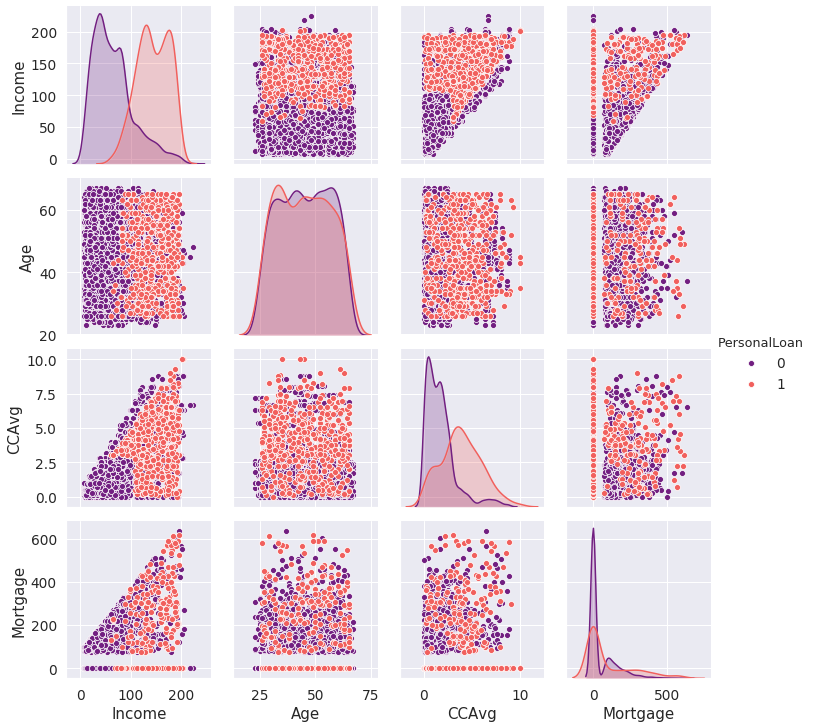

In [15]:
cols = ['Income', 'Age', 'CCAvg', 'Mortgage', 'PersonalLoan']
sns.pairplot(df[cols], hue='PersonalLoan', palette='magma')

### Income

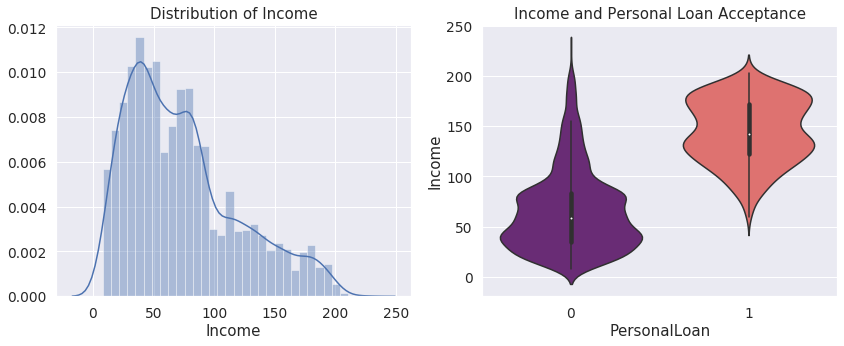

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,5))

ax1.set_title("Distribution of Income")
sns.distplot(df["Income"], ax=ax1)

ax2.set_title("Income and Personal Loan Acceptance")
sns.violinplot(x='PersonalLoan', y ='Income', data=df, palette='magma', ax=ax2)

### Education

Text(0.5, 1.0, 'Accepted')

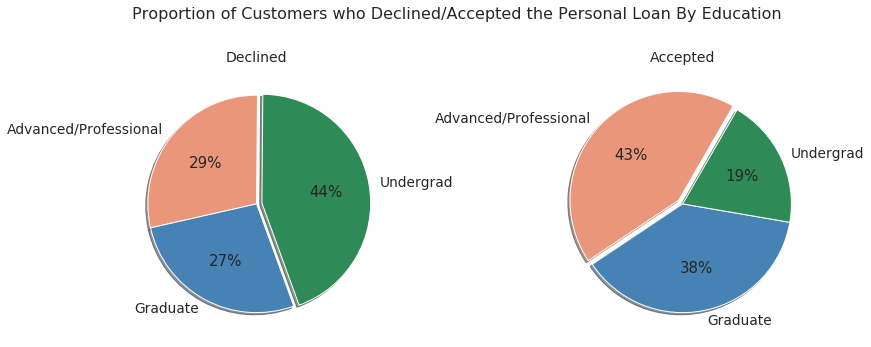

In [17]:
series_declined = df[df['PersonalLoan'] == 0]['Education'].value_counts()
series_accepted = df[df['PersonalLoan'] == 1]['Education'].value_counts()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,5),subplot_kw=dict(aspect="equal"))
fig.suptitle('Proportion of Customers who Declined/Accepted the Personal Loan By Education', fontsize=16, y=1.05);

explode = (0.05, 0.0, 0.0)

labels = ['Undergrad', 'Advanced/Professional', 'Graduate']
colors = ['seagreen', 'darksalmon', 'steelblue']
ax1.pie(series_declined, colors=colors, labels=labels, autopct='%1.0f%%', shadow=True, explode=explode, startangle=-70)
ax1.set_title('Declined', fontsize=14)

labels = ['Advanced/Professional', 'Graduate', 'Undergrad']
colors = ['darksalmon', 'steelblue', 'seagreen']
ax2.pie(series_accepted, colors=colors, labels=labels, autopct='%1.0f%%', shadow=True, explode=explode, startangle=60)
ax2.set_title('Accepted', fontsize=14)

### CCAvg

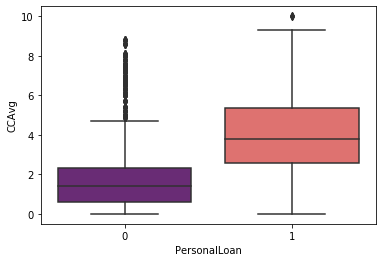

In [8]:
sns.boxplot(x='PersonalLoan', y='CCAvg', data=df, palette='magma')

### Family

([<matplotlib.patches.Wedge at 0x7f95893d8b00>,
 [Text(-1.345473213113224, 1.119018245067871, '4'),
  Text(-0.8650620765197772, -1.521238838502124, '3'),
  Text(1.4777748716877777, -0.8403460171906407, '1'),
  Text(1.0870462952087891, 1.3070311213099888, '2')],
 [Text(-0.7688418360646994, 0.6394389971816404, '27.9%'),
  Text(-0.4943211865827297, -0.8692793362869279, '27.7%'),
  Text(0.8258153694725815, -0.4696051272535933, '22.3%'),
  Text(0.6074670473225585, 0.7303997442614643, '22.1%')])

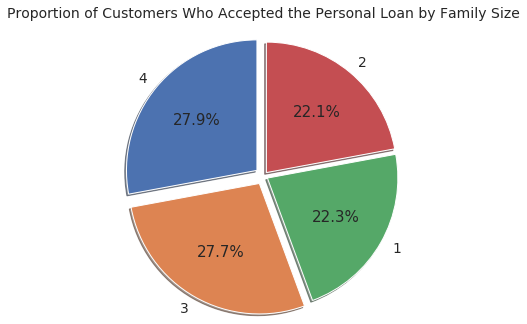

In [19]:
series = df[df['PersonalLoan'] == 1]['Family'].value_counts()

plt.axis('equal')
plt.title('Proportion of Customers Who Accepted the Personal Loan by Family Size', fontsize=14, y=1.2)
labels = ['4', '3', '1', '2']
plt.pie(series, labels=labels, autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1, 0.05, 0.05), radius=1.5, startangle=90)

### CD Account

Text(0.5, 1.0, 'Accepted')

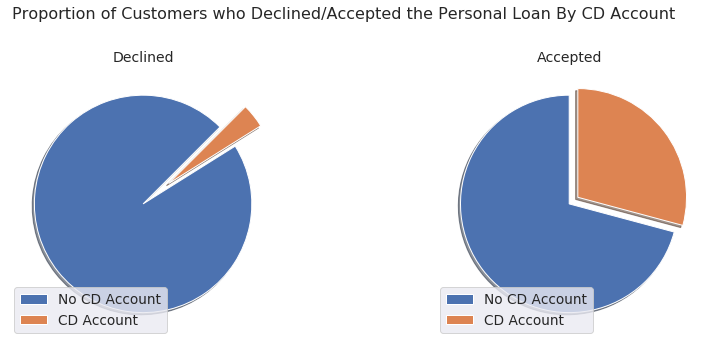

In [20]:
series_declined = df[df['PersonalLoan'] == 0]['CDAccount'].value_counts()
series_accepted = df[df['PersonalLoan'] == 1]['CDAccount'].value_counts()

labels = ['No CD Account', 'CD Account']
colors = ['lightcoral', 'yellowgreen']

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,5),subplot_kw=dict(aspect="equal"))
fig.suptitle('Proportion of Customers who Declined/Accepted the Personal Loan By CD Account', fontsize=16, y=1.05);

patches, texts = ax1.pie(series_declined, shadow=True, explode=(0, 0.3), startangle=45)
ax1.legend(patches, labels, loc="best")
ax1.set_title('Declined', fontsize=14)

patches, texts = ax2.pie(series_accepted, shadow=True, explode=(0, 0.1), startangle=90)
ax2.legend(patches, labels, loc="best")
ax2.set_title('Accepted', fontsize=14)

### Age & Experience
The correlation matrix indicated an extremely tight correlation between Age and Experience. Below is a scatter plot portraying a linear correlation between Age and Experience. 

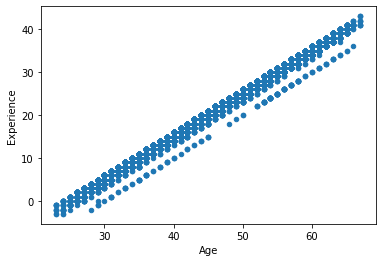

In [7]:
data = pd.concat([df['Age'], df['Experience']], axis=1)
data.plot.scatter(x='Age', y='Experience')

One of these redundant features should be removed to simplify the solution and prevent multicollinearity. Experience will be removed since it already had some garbage data and it did not have a significant correlation with PersonalLoan.

In [22]:
df.drop(columns=['Experience'], inplace=True)

#### Visualizations Conclusions
There appears to be a strong correlation between PersonalLoan and Income. Those who accepted the Personal Loan had higher incomes.

Those who did not accept the personal loan tend to be concentrated around the lower Income and CCAvg areas. 

CDAccount was not as significant a feature as anticipated.

Mortgage and Income have a bit of a correlation. A mortgage amount does not exceed a certain threshold in regards to the income. It seems that the mortgage amount was indicative of a factor due to the Income.

# Train Model

In [115]:
features = ['Income', 'Education', 'CCAvg', 'Family', 'CDAccount', 'Age']

X = df[features]
y = df.PersonalLoan

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=27, stratify=y)

In [88]:
# SMOTE
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [89]:
# Random Undersampler
rus = RandomUnderSampler(random_state=27)
X_train, y_train = rus.fit_resample(X_train, y_train.ravel())

In [111]:
# K-Neighbors
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)

print('K Neighbors Classifier')
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

K Neighbors Classifier
Confusion Matrix:
      0    1
0  1329   27
1    11  133
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1356
           1       0.83      0.92      0.88       144

    accuracy                           0.97      1500
   macro avg       0.91      0.95      0.93      1500
weighted avg       0.98      0.97      0.98      1500

Accuracy: 0.9746666666666667
Recall: 0.9236111111111112
F1: 0.875
ROC AUC: 0.9518498033431662


In [107]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Random Forest Classifier')
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

Random Forest Classifier
Confusion Matrix:
      0    1
0  1344   12
1     4  140
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1356
           1       0.92      0.97      0.95       144

    accuracy                           0.99      1500
   macro avg       0.96      0.98      0.97      1500
weighted avg       0.99      0.99      0.99      1500

Accuracy: 0.9893333333333333
Recall: 0.9722222222222222
F1: 0.9459459459459458
ROC AUC: 0.9816863323500492


In [114]:
# Dump the trained Random Forest Classifier with Pickle
rfc_model_pkl_filename = 'personal_loan_prediction_model.pkl'

# Open the file to save as pkl file
rfc_model_pkl = open(rfc_model_pkl_filename, 'wb')
pickle.dump(rfc, rfc_model_pkl)

# Close the pickle instances
rfc_model_pkl.close()

In [116]:
# Dump the Scaler with Pickle
model_scaler_pkl_filename = 'personal_loan_prediction_scaler.pkl'

# Open the file to save as pkl file
model_scaler_pkl = open(model_scaler_pkl_filename, 'wb')
pickle.dump(scaler, model_scaler_pkl)

# Close the pickle instances
model_scaler_pkl.close()